
 ***Understanding SafeGraph Mobility Data for Pickens, SC (Feb 2020)***
>



In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

print("Step 1: Libraries imported successfully!")

Step 1: Libraries imported successfully!


In [ ]:
# Upload the dataset to Colab or use the path if it's already available
# To upload: from google.colab import files
# uploaded = files.upload()

# Load the CSV file
df = pd.read_csv('nj_union_sept2021_total_match.csv')

# Display basic information
print("Step 2: Dataset loaded")
print(f"Number of rows: {len(df)}")
print(f"Number of columns: {len(df.columns)}")

# Check if the additional columns exist in the dataset
requested_columns = ['sg_c__postal_code', 'sg_c__latitude', 'sg_c__longitude',
                     'sg_c__top_category', 'sg_c__sub_category']

existing_columns = [col for col in requested_columns if col in df.columns]
missing_columns = [col for col in requested_columns if col not in df.columns]

print("\nRequested columns that exist in the dataset:")
print(existing_columns)

print("\nRequested columns that are missing from the dataset:")
print(missing_columns)

# Preview the first few rows focusing on key columns
cols_to_display = ['date_range_start', 'date_range_end', 'sg_wp__location_name',
                  'sg_wp__postal_code', 'sg_wp__visits_by_day'] + existing_columns

print("\nPreview of first 2 rows with key columns:")
print(df[cols_to_display].head(2))

Step 2: Dataset loaded
Number of rows: 3980
Number of columns: 55

Requested columns that exist in the dataset:
['sg_c__postal_code', 'sg_c__latitude', 'sg_c__longitude', 'sg_c__top_category', 'sg_c__sub_category']

Requested columns that are missing from the dataset:
[]

Preview of first 2 rows with key columns:
  date_range_start date_range_end              sg_wp__location_name  \
0       2021-08-23     2021-08-30  Westfield Veterinary Group Union   
1       2021-08-23     2021-08-30                    Autosound Plus   

   sg_wp__postal_code sg_wp__visits_by_day  sg_c__postal_code  sg_c__latitude  \
0                7083      [3,3,2,2,1,6,3]             7083.0       40.688011   
1                7083      [1,4,1,1,3,1,0]             7083.0       40.697982   

   sg_c__longitude                                 sg_c__top_category  \
0       -74.243413  Other Professional, Scientific, and Technical ...   
1       -74.247700                   Electronics and Appliance Stores   

    sg_

In [ ]:
# This step adds placeholder columns if the requested columns don't exist
print("Step 3: Handling missing columns")

# Add missing columns with placeholder values
for col in missing_columns:
    df[col] = None
    print(f"Added placeholder column: {col}")

# Use sg_wp__postal_code if sg_c__postal_code is missing or empty
if 'sg_c__postal_code' in missing_columns or df['sg_c__postal_code'].isna().all():
    df['sg_c__postal_code'] = df['sg_wp__postal_code']
    print("Using sg_wp__postal_code as a substitute for sg_c__postal_code")

print("\nDataset now has all requested columns (original or placeholder)")

Step 3: Handling missing columns

Dataset now has all requested columns (original or placeholder)


In [ ]:
def parse_visits_array(array_str):
    """Convert string representation of an array to a Python list of integers"""
    # Handle NaN or empty strings
    if pd.isna(array_str) or array_str == '':
        return []

    # Remove brackets and spaces, then split by comma
    clean_str = array_str.replace('[', '').replace(']', '').replace(' ', '')

    # Convert to list of integers
    try:
        return [int(x) for x in clean_str.split(',')]
    except:
        print(f"Error parsing: {array_str}")
        return []

print("Step 4: Created function to parse visit arrays")

# Test the function on a few examples
for i in range(3):
    visits_str = df['sg_wp__visits_by_day'].iloc[i]
    visits_list = parse_visits_array(visits_str)
    print(f"Row {i}: String: {visits_str} → List: {visits_list}")

Step 4: Created function to parse visit arrays
Row 0: String: [3,3,2,2,1,6,3] → List: [3, 3, 2, 2, 1, 6, 3]
Row 1: String: [1,4,1,1,3,1,0] → List: [1, 4, 1, 1, 3, 1, 0]
Row 2: String: [1,0,0,1,1,0,0] → List: [1, 0, 0, 1, 1, 0, 0]


In [ ]:
def generate_dates(start_date_str):
    """Generate a list of 7 consecutive dates starting from start_date_str"""
    # Parse the start date string to a datetime object
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')

    # Generate 7 consecutive dates (for a week)
    dates = [start_date + timedelta(days=i) for i in range(7)]

    # Convert back to string format
    date_strings = [date.strftime('%Y-%m-%d') for date in dates]

    return date_strings

print("Step 5: Created function to generate dates")

# Test the function on the first row
start_date = df['date_range_start'].iloc[0]
date_list = generate_dates(start_date)
print(f"Start date: {start_date}")
print(f"Generated dates: {date_list}")

Step 5: Created function to generate dates
Start date: 2021-08-23
Generated dates: ['2021-08-23', '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-28', '2021-08-29']


In [ ]:
print("Step 6: Expanding the dataset - extracting date-specific visits (sample)")

# Create an empty list to store the expanded data
expanded_data = []

# Process the first 5 rows as a demonstration
sample_rows = min(5, len(df))

for idx in range(sample_rows):
    row = df.iloc[idx]

    # Get location information
    location_name = row['sg_wp__location_name']
    placekey = row['placekey']
    address = row['sg_wp__street_address']

    # Get the additional columns
    postal_code = row['sg_c__postal_code']
    latitude = row['sg_c__latitude']
    longitude = row['sg_c__longitude']
    top_category = row['sg_c__top_category']
    sub_category = row['sg_c__sub_category']

    # Parse dates and visits
    start_date_str = row['date_range_start']
    dates = generate_dates(start_date_str)
    visits = parse_visits_array(row['sg_wp__visits_by_day'])

    # Ensure visits list has 7 elements (some might be truncated in the data)
    if len(visits) < 7:
        visits = visits + [0] * (7 - len(visits))

    # Create a row for each day
    for i, (date, visit_count) in enumerate(zip(dates, visits)):
        # Get day of week
        day_date = datetime.strptime(date, '%Y-%m-%d')
        day_name = day_date.strftime('%A')  # Monday, Tuesday, etc.

        expanded_data.append({
            'placekey': placekey,
            'location_name': location_name,
            'address': address,
            'date': date,
            'day_of_week': day_name,
            'visits': visit_count,
            'postal_code': postal_code,
            'latitude': latitude,
            'longitude': longitude,
            'top_category': top_category,
            'sub_category': sub_category
        })

# Convert to dataframe
sample_expanded_df = pd.DataFrame(expanded_data)

# Show the expanded data
print(f"\nExpanded {sample_rows} rows into {len(sample_expanded_df)} date-specific entries")
print(sample_expanded_df.head())

Step 6: Expanding the dataset - extracting date-specific visits (sample)

Expanded 5 rows into 35 date-specific entries
              placekey                     location_name          address  \
0  222-222@627-wkz-nt9  Westfield Veterinary Group Union  1325 Morris Ave   
1  222-222@627-wkz-nt9  Westfield Veterinary Group Union  1325 Morris Ave   
2  222-222@627-wkz-nt9  Westfield Veterinary Group Union  1325 Morris Ave   
3  222-222@627-wkz-nt9  Westfield Veterinary Group Union  1325 Morris Ave   
4  222-222@627-wkz-nt9  Westfield Veterinary Group Union  1325 Morris Ave   

         date day_of_week  visits  postal_code   latitude  longitude  \
0  2021-08-23      Monday       3       7083.0  40.688011 -74.243413   
1  2021-08-24     Tuesday       3       7083.0  40.688011 -74.243413   
2  2021-08-25   Wednesday       2       7083.0  40.688011 -74.243413   
3  2021-08-26    Thursday       2       7083.0  40.688011 -74.243413   
4  2021-08-27      Friday       1       7083.0  40.688011

In [ ]:
print("Step 7: Processing the entire dataset")

# Reset expanded_data list
expanded_data = []

# Process all rows
for idx, row in df.iterrows():
    # Get location information
    location_name = row['sg_wp__location_name']
    placekey = row['placekey']
    address = row['sg_wp__street_address']

    # Get the additional columns
    postal_code = row['sg_c__postal_code']
    latitude = row['sg_c__latitude']
    longitude = row['sg_c__longitude']
    top_category = row['sg_c__top_category']
    sub_category = row['sg_c__sub_category']

    # Parse dates and visits
    start_date_str = row['date_range_start']
    dates = generate_dates(start_date_str)

    # Handle potential errors in visits_by_day column
    try:
        visits = parse_visits_array(row['sg_wp__visits_by_day'])

        # Ensure visits list has 7 elements
        if len(visits) < 7:
            visits = visits + [0] * (7 - len(visits))

        # Create a row for each day
        for i, (date, visit_count) in enumerate(zip(dates, visits)):
            # Get day of week
            day_date = datetime.strptime(date, '%Y-%m-%d')
            day_name = day_date.strftime('%A')

            expanded_data.append({
                'placekey': placekey,
                'location_name': location_name,
                'address': address,
                'date': date,
                'day_of_week': day_name,
                'visits': visit_count,
                'postal_code': postal_code,
                'latitude': latitude,
                'longitude': longitude,
                'top_category': top_category,
                'sub_category': sub_category
            })
    except Exception as e:
        print(f"Error processing row {idx} ({location_name}): {e}")

    # Print progress every 50 rows
    if idx % 50 == 0 and idx > 0:
        print(f"Processed {idx} of {len(df)} rows...")

# Convert to dataframe
expanded_df = pd.DataFrame(expanded_data)

print(f"\nExpanded dataset created successfully!")
print(f"Original rows: {len(df)}")
print(f"Expanded rows: {len(expanded_df)}")

Step 7: Processing the entire dataset
Processed 50 of 3980 rows...
Processed 100 of 3980 rows...
Processed 150 of 3980 rows...
Processed 200 of 3980 rows...
Processed 250 of 3980 rows...
Processed 300 of 3980 rows...
Processed 350 of 3980 rows...
Processed 400 of 3980 rows...
Processed 450 of 3980 rows...
Processed 500 of 3980 rows...
Processed 550 of 3980 rows...
Processed 600 of 3980 rows...
Processed 650 of 3980 rows...
Processed 700 of 3980 rows...
Processed 750 of 3980 rows...
Processed 800 of 3980 rows...
Processed 850 of 3980 rows...
Processed 900 of 3980 rows...
Processed 950 of 3980 rows...
Processed 1000 of 3980 rows...
Processed 1050 of 3980 rows...
Processed 1100 of 3980 rows...
Processed 1150 of 3980 rows...
Processed 1200 of 3980 rows...
Processed 1250 of 3980 rows...
Processed 1300 of 3980 rows...
Processed 1350 of 3980 rows...
Processed 1400 of 3980 rows...
Processed 1450 of 3980 rows...
Processed 1500 of 3980 rows...
Processed 1550 of 3980 rows...
Processed 1600 of 398

In [ ]:
print("Step 8: Exploring the expanded dataset")

# Basic information
print(f"Shape: {expanded_df.shape}")
print(f"Columns: {expanded_df.columns.tolist()}")
print("\nSample of expanded data:")
print(expanded_df.head())

# Check for missing values in the geographic columns
print("\nMissing values in additional columns:")
geo_cols = ['postal_code', 'latitude', 'longitude', 'top_category', 'sub_category']
for col in geo_cols:
    missing = expanded_df[col].isna().sum()
    total = len(expanded_df)
    percent = (missing / total) * 100
    print(f"{col}: {missing} missing values ({percent:.2f}%)")

# Summarize visits by date
print("\nTotal visits by date:")
daily_visits = expanded_df.groupby('date')['visits'].sum()
print(daily_visits)

# Summarize visits by day of week
print("\nTotal visits by day of week:")
dow_visits = expanded_df.groupby('day_of_week')['visits'].sum()
print(dow_visits)

# If category data is available, summarize by category
if expanded_df['top_category'].notna().any():
    print("\nTotal visits by top category:")
    cat_visits = expanded_df.groupby('top_category')['visits'].sum().sort_values(ascending=False)
    print(cat_visits.head(10))  # Show top 10 categories

Step 8: Exploring the expanded dataset
Shape: (27860, 11)
Columns: ['placekey', 'location_name', 'address', 'date', 'day_of_week', 'visits', 'postal_code', 'latitude', 'longitude', 'top_category', 'sub_category']

Sample of expanded data:
              placekey                     location_name          address  \
0  222-222@627-wkz-nt9  Westfield Veterinary Group Union  1325 Morris Ave   
1  222-222@627-wkz-nt9  Westfield Veterinary Group Union  1325 Morris Ave   
2  222-222@627-wkz-nt9  Westfield Veterinary Group Union  1325 Morris Ave   
3  222-222@627-wkz-nt9  Westfield Veterinary Group Union  1325 Morris Ave   
4  222-222@627-wkz-nt9  Westfield Veterinary Group Union  1325 Morris Ave   

         date day_of_week  visits  postal_code   latitude  longitude  \
0  2021-08-23      Monday       3       7083.0  40.688011 -74.243413   
1  2021-08-24     Tuesday       3       7083.0  40.688011 -74.243413   
2  2021-08-25   Wednesday       2       7083.0  40.688011 -74.243413   
3  2021-08

Step 9: Visualizing the data


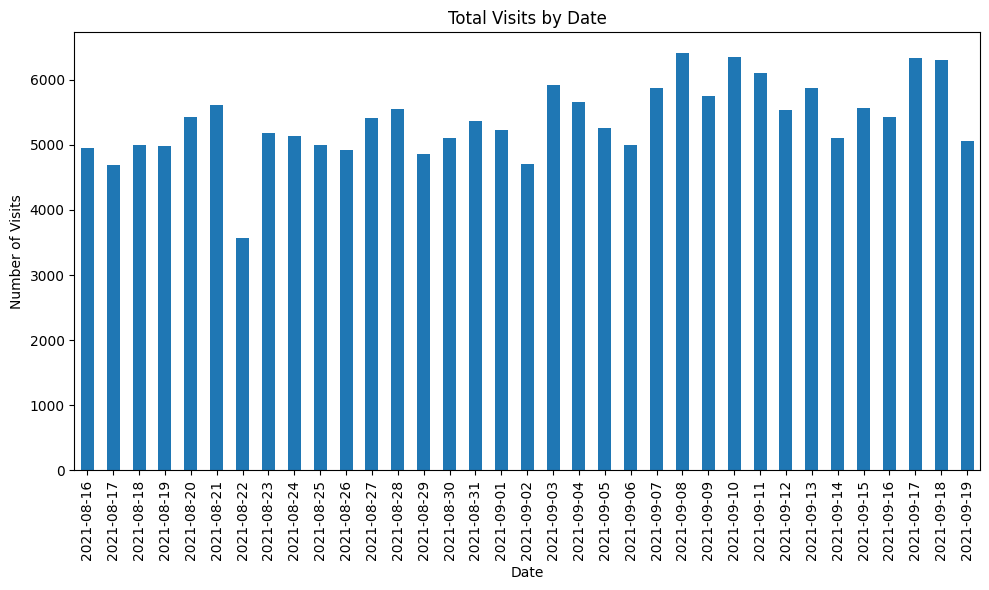

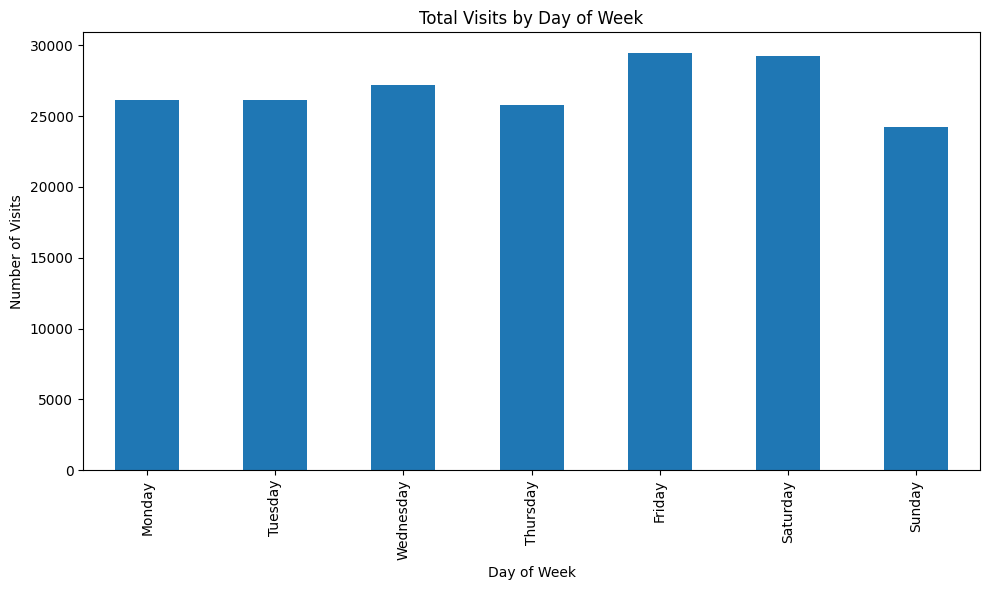

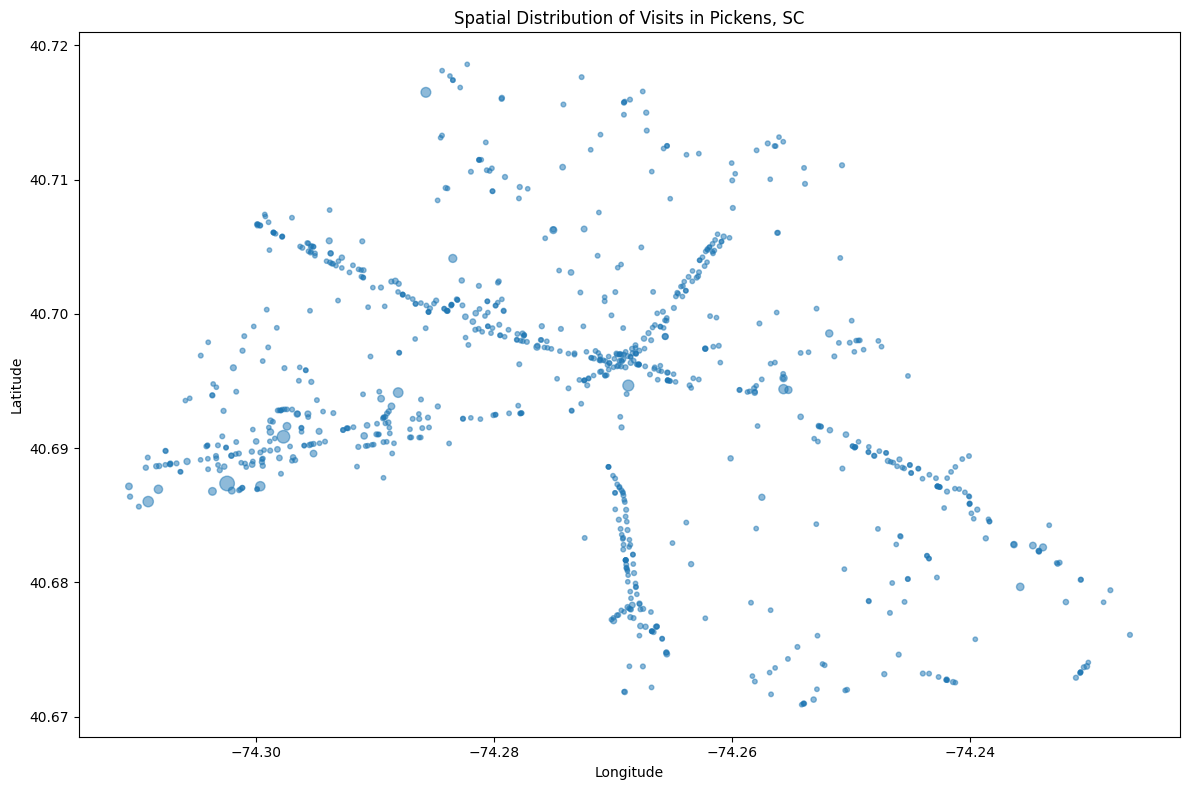

Created basic spatial visualization


In [ ]:
print("Step 9: Visualizing the data")

# Plot total visits by date
plt.figure(figsize=(10, 6))
daily_visits.plot(kind='bar', title='Total Visits by Date')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.tight_layout()
plt.show()

# Plot total visits by day of week
plt.figure(figsize=(10, 6))
# Reorder days of week correctly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_visits_ordered = dow_visits.reindex(days_order)
dow_visits_ordered.plot(kind='bar', title='Total Visits by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Visits')
plt.tight_layout()
plt.show()

# If we have geographic data, create a basic spatial visualization
if expanded_df['latitude'].notna().any() and expanded_df['longitude'].notna().any():
    try:
        # Aggregate visits by location
        geo_data = expanded_df.groupby(['location_name', 'latitude', 'longitude'])['visits'].sum().reset_index()

        # Normalize visit counts for marker size
        max_visits = geo_data['visits'].max()
        geo_data['marker_size'] = geo_data['visits'] / max_visits * 100 + 10  # Scale for visibility

        # Plot on a scatter plot (not a true map, but gives spatial distribution)
        plt.figure(figsize=(12, 8))
        plt.scatter(geo_data['longitude'], geo_data['latitude'],
                   s=geo_data['marker_size'], alpha=0.5)
        plt.title('Spatial Distribution of Visits in Pickens, SC')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.tight_layout()
        plt.show()

        print("Created basic spatial visualization")
    except Exception as e:
        print(f"Could not create spatial visualization: {e}")

Step 10: Category analysis (if available)


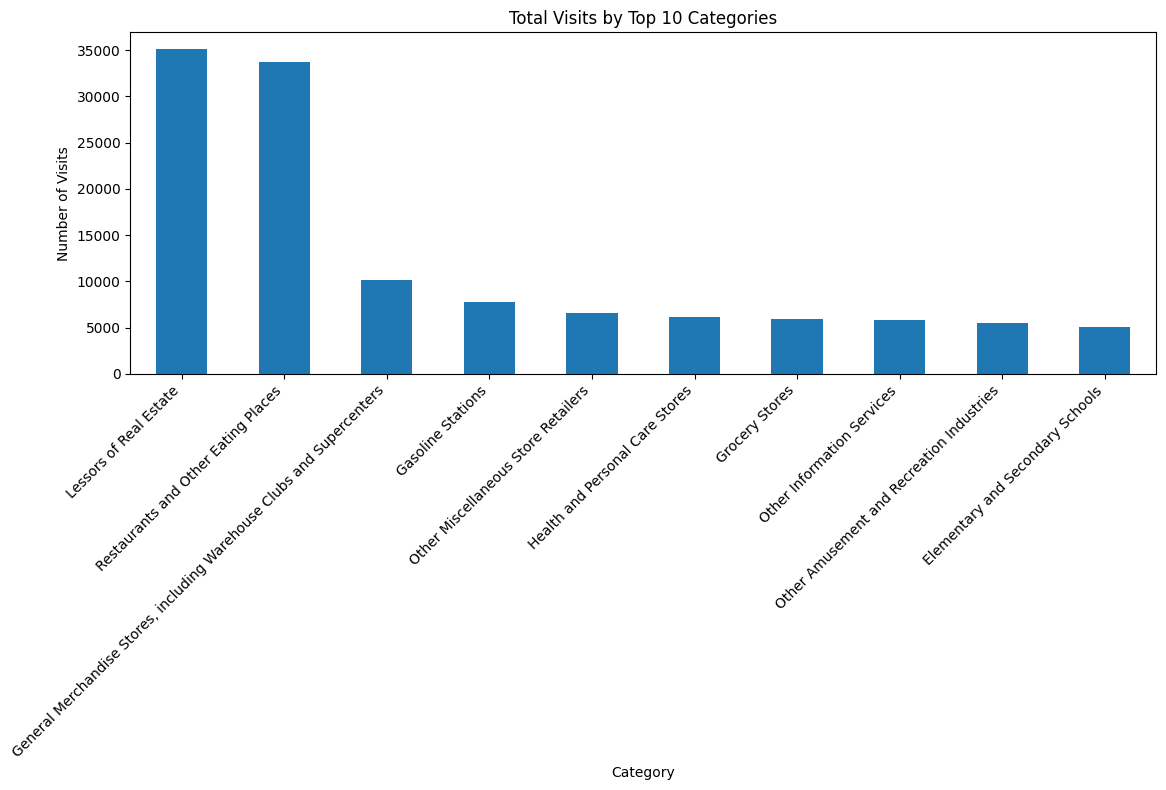

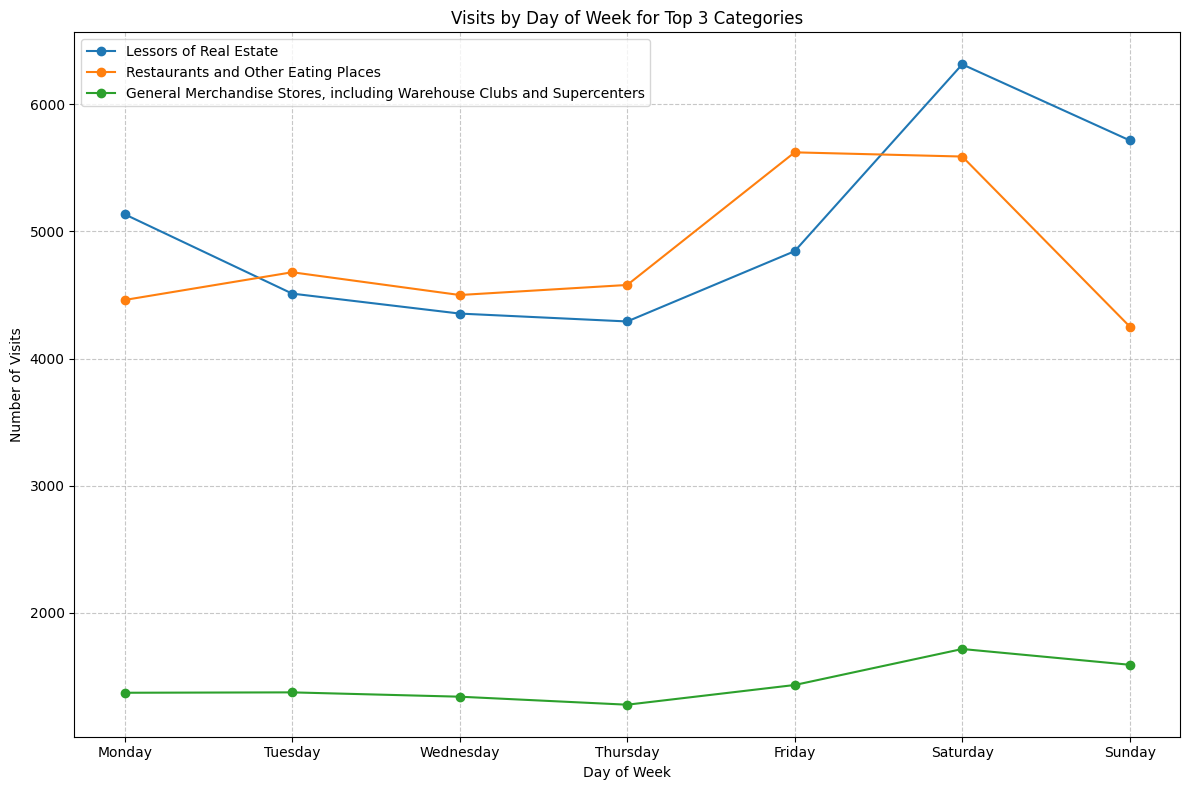

In [ ]:
print("Step 10: Category analysis (if available)")

# Check if we have category data
if expanded_df['top_category'].notna().any():
    # Visits by top category
    plt.figure(figsize=(12, 8))
    cat_visits = expanded_df.groupby('top_category')['visits'].sum().sort_values(ascending=False).head(10)
    cat_visits.plot(kind='bar', title='Total Visits by Top 10 Categories')
    plt.xlabel('Category')
    plt.ylabel('Number of Visits')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Visits by day of week for top 3 categories
    top_cats = cat_visits.index[:3].tolist()

    plt.figure(figsize=(12, 8))
    for cat in top_cats:
        cat_data = expanded_df[expanded_df['top_category'] == cat]
        cat_dow = cat_data.groupby('day_of_week')['visits'].sum()
        cat_dow_ordered = cat_dow.reindex(days_order)
        plt.plot(days_order, cat_dow_ordered, marker='o', label=cat)

    plt.title('Visits by Day of Week for Top 3 Categories')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Visits')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No category data available for analysis")

In [ ]:
print("Step 11: Saving expanded dataset to CSV")

# Save to CSV
expanded_df.to_csv('pickens_sc_daily_visits_with_geo_feb2020.csv', index=False)
print("Dataset saved successfully to 'pickens_sc_daily_visits_with_geo_feb2020.csv'")

# Summary of the expanded dataset
print("\nFinal dataset summary:")
print(f"Total locations: {expanded_df['placekey'].nunique()}")
print(f"Date range: {expanded_df['date'].min()} to {expanded_df['date'].max()}")
print(f"Total visits recorded: {expanded_df['visits'].sum()}")

# Additional geographic summary
if expanded_df['postal_code'].notna().any():
    print(f"Number of distinct postal codes: {expanded_df['postal_code'].nunique()}")

if expanded_df['top_category'].notna().any():
    print(f"Number of distinct categories: {expanded_df['top_category'].nunique()}")

Step 11: Saving expanded dataset to CSV
Dataset saved successfully to 'pickens_sc_daily_visits_with_geo_feb2020.csv'

Final dataset summary:
Total locations: 884
Date range: 2021-08-16 to 2021-09-19
Total visits recorded: 188148
Number of distinct postal codes: 1
Number of distinct categories: 93


Step 12: Postal code analysis

Total visits by postal code:
postal_code
7083.0    185927
Name: visits, dtype: int64


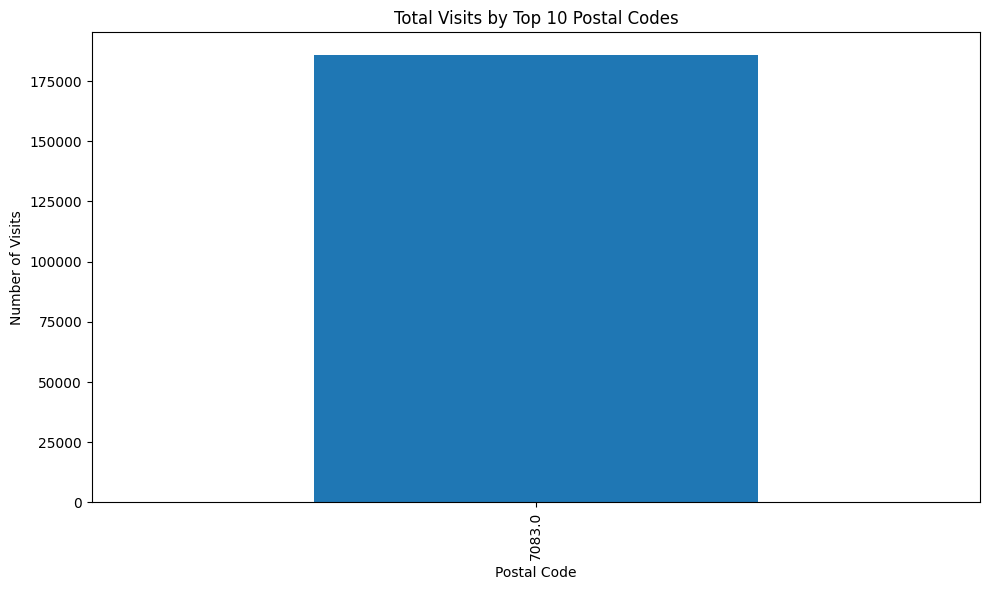

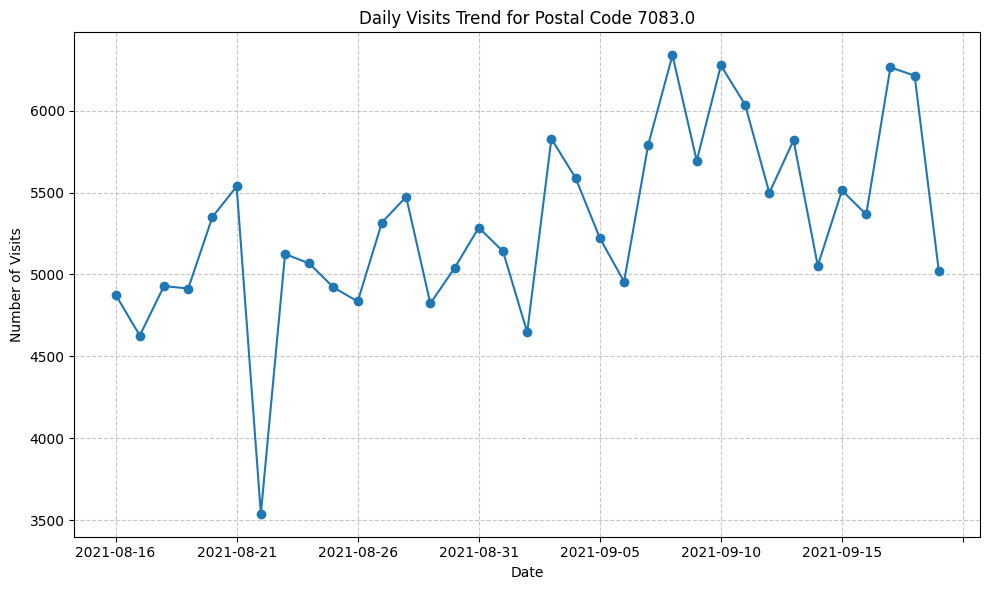

In [ ]:
print("Step 12: Postal code analysis")

# If postal code data is available
if expanded_df['postal_code'].notna().any():
    # Visits by postal code
    postal_visits = expanded_df.groupby('postal_code')['visits'].sum().sort_values(ascending=False)

    print("\nTotal visits by postal code:")
    print(postal_visits)

    # Plot visits by postal code
    plt.figure(figsize=(10, 6))
    postal_visits.head(10).plot(kind='bar', title='Total Visits by Top 10 Postal Codes')
    plt.xlabel('Postal Code')
    plt.ylabel('Number of Visits')
    plt.tight_layout()
    plt.show()

    # Daily trend for top postal code
    top_postal = postal_visits.index[0]
    top_postal_data = expanded_df[expanded_df['postal_code'] == top_postal]
    daily_trend = top_postal_data.groupby('date')['visits'].sum()

    plt.figure(figsize=(10, 6))
    daily_trend.plot(kind='line', marker='o', title=f'Daily Visits Trend for Postal Code {top_postal}')
    plt.xlabel('Date')
    plt.ylabel('Number of Visits')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No postal code data available for analysis")

In [ ]:
# Code to download all generated figures and CSV files
from google.colab import files
import os
import matplotlib.pyplot as plt

# Step 1: Save all figures to files
print("Step 1: Saving all figures...")

# Function to save the current figure
def save_figure(name):
    plt.savefig(name, dpi=300, bbox_inches='tight')
    print(f"Saved figure: {name}")

# Daily visits figure
plt.figure(figsize=(10, 6))
daily_visits.plot(kind='bar', title='Total Visits by Date')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.tight_layout()
save_figure('daily_visits.png')
plt.close()

# Day of week visits figure
plt.figure(figsize=(10, 6))
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_visits_ordered = dow_visits.reindex(days_order)
dow_visits_ordered.plot(kind='bar', title='Total Visits by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Visits')
plt.tight_layout()
save_figure('day_of_week_visits.png')
plt.close()

# If category data exists, save category figure
if 'top_category' in expanded_df.columns and expanded_df['top_category'].notna().any():
    plt.figure(figsize=(12, 8))
    cat_visits = expanded_df.groupby('top_category')['visits'].sum().sort_values(ascending=False).head(10)
    cat_visits.plot(kind='bar', title='Total Visits by Top 10 Categories')
    plt.xlabel('Category')
    plt.ylabel('Number of Visits')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    save_figure('category_visits.png')
    plt.close()

# If latitude/longitude data exists, save spatial visualization
if 'latitude' in expanded_df.columns and 'longitude' in expanded_df.columns and expanded_df['latitude'].notna().any():
    plt.figure(figsize=(12, 8))
    geo_data = expanded_df.groupby(['location_name', 'latitude', 'longitude'])['visits'].sum().reset_index()
    max_visits = geo_data['visits'].max()
    geo_data['marker_size'] = geo_data['visits'] / max_visits * 100 + 10
    plt.scatter(geo_data['longitude'], geo_data['latitude'], s=geo_data['marker_size'], alpha=0.5)
    plt.title('Spatial Distribution of Visits in Pickens, SC')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    save_figure('spatial_distribution.png')
    plt.close()

# If postal code data exists, save postal code figure
if 'postal_code' in expanded_df.columns and expanded_df['postal_code'].notna().any():
    plt.figure(figsize=(10, 6))
    postal_visits = expanded_df.groupby('postal_code')['visits'].sum().sort_values(ascending=False)
    postal_visits.head(10).plot(kind='bar', title='Total Visits by Top 10 Postal Codes')
    plt.xlabel('Postal Code')
    plt.ylabel('Number of Visits')
    plt.tight_layout()
    save_figure('postal_code_visits.png')
    plt.close()

# Step 2: Save the expanded dataset to CSV
print("\nStep 2: Saving CSV file...")
expanded_df.to_csv('pickens_sc_daily_visits_complete.csv', index=False)
print("Saved CSV: pickens_sc_daily_visits_complete.csv")

# Step 3: Download all generated files
print("\nStep 3: Downloading all files...")
generated_files = [f for f in os.listdir() if f.endswith('.png') or f.endswith('.csv')]

for file in generated_files:
    files.download(file)
    print(f"Downloaded: {file}")

print("\nAll figures and CSV files have been downloaded successfully!")

Step 1: Saving all figures...
Saved figure: daily_visits.png
Saved figure: day_of_week_visits.png
Saved figure: category_visits.png
Saved figure: spatial_distribution.png
Saved figure: postal_code_visits.png

Step 2: Saving CSV file...
Saved CSV: pickens_sc_daily_visits_complete.csv

Step 3: Downloading all files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: daily_visits.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: pickens_sc_daily_visits_with_geo_feb2020.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: nj_union_sept2021_total_match.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: spatial_distribution.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: pickens_sc_daily_visits_complete.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: postal_code_visits.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: category_visits.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: day_of_week_visits.png

All figures and CSV files have been downloaded successfully!
